# Forgetting as retrieval failure, and recovery by memory reactivation

NB: we recommend using a GPU for this simulation; remember to enable the GPU in the notebook setting if you are using Google Colab

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [2]:
!python --version

Python 3.10.12


In [3]:
torch.__version__

'2.5.1+cu121'

In [4]:
!nvidia-smi

Wed Dec 18 20:21:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
# See https://pytorch.org/docs/stable/notes/randomness.html
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    # torch.backends.cudnn.deterministic = True

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Hyper-parameters
input_size = 784
hidden_size = 64
num_classes = 4  # class-incremental continual learning with 2 tasks and 2 classes

# for training:
batch_size = 128
learning_rate = 0.0006
momentum = 0.0

In [8]:
# Prepare MNIST dataset

# train
train_set = torchvision.datasets.MNIST(
    root='./data', train=True, transform=transforms.ToTensor(), download=True)

# restrict number of classes
idx = train_set.train_labels<2
train_set.targets = train_set.targets[idx]
train_set.data = train_set.data[idx]

train_loader = torch.utils.data.DataLoader(
    dataset=train_set, batch_size=batch_size, shuffle=False, pin_memory=True)

# test
test_set = torchvision.datasets.MNIST(
    root='./data', train=False, transform=transforms.ToTensor(), download=True)

# restrict number of classes
idx = test_set.train_labels<2
test_set.targets = test_set.targets[idx]
test_set.data = test_set.data[idx]

test_loader = torch.utils.data.DataLoader(
    dataset=test_set, batch_size=batch_size, shuffle=False, pin_memory=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 4.99MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.03MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [9]:
# Prepare FashionMNIST dataset

# train
f_train_set = torchvision.datasets.FashionMNIST(
    root='./data', train=True, transform=transforms.ToTensor(), download=True)

# restrict number of classes
idx = torch.logical_and(f_train_set.train_labels<num_classes, 1<f_train_set.train_labels)
f_train_set.targets = f_train_set.targets[idx]
f_train_set.data = f_train_set.data[idx]

f_train_loader = torch.utils.data.DataLoader(
    dataset=f_train_set, batch_size=batch_size, shuffle=False, pin_memory=True)

# test
f_test_set = torchvision.datasets.FashionMNIST(
    root='./data', train=False, transform=transforms.ToTensor(), download=True)

idx = torch.logical_and(f_test_set.train_labels<num_classes, 1<f_test_set.train_labels)

f_test_set.targets = f_test_set.targets[idx]
f_test_set.data = f_test_set.data[idx]

f_test_loader = torch.utils.data.DataLoader(
    dataset=f_test_set, batch_size=batch_size, shuffle=False, pin_memory=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.9MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 175kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.30MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 14.1MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [10]:
## NB: Since the goal of this simulation is to experiment with the memory recovery
## after forgetting, there is no issue tracking the test performance during training.
## Nevertheless, if you do not feel comfortable doing so, one can hold out a subset
## of the training set for validation as usual/as follows, and use the corresponding
## valid_loader in lieu of test_loader (this does not change the conclusion).

# # MNIST
# idx = np.arange(len(train_set))
# val_indices = idx[len(train_set.targets)-1665:]
# train_indices= idx[:-1665]

# train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
# valid_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

# train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
#                                            sampler=train_sampler, num_workers=2)

# valid_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
#                                            sampler=valid_sampler, num_workers=2)

# # FashionMNIST
# idx = np.arange(len(f_train_set))

# val_indices = idx[len(f_train_set.targets)-1000:]
# train_indices= idx[:-1000]

# f_train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
# f_valid_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

# f_train_loader = torch.utils.data.DataLoader(
#     f_train_set, batch_size=batch_size, sampler=f_train_sampler, num_workers=2)

# f_valid_loader = torch.utils.data.DataLoader(
#     f_train_set, batch_size=batch_size, sampler=f_valid_sampler, num_workers=2)

## Model definition

NB: In this notebook, we opt for the following memory-efficient implementation that does not materialize the key-value memory pairs for each learning step; instead, we store the equivalent, linear layer weights, separately for the two tasks. Amplifying the weights corresponding to Task 1 is mathematically equivalent to amplifying the Task-1 key-value memories as described in the paper. Those interested in going beyond experiments described in our paper, e.g., ablating/manipulating the actual key-value memories, will need to implement the model differently.

In [11]:
# Model definition (see text above)

class SuperpositionMLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()

        self.input_layer1 = nn.Linear(input_size, hidden_size, bias=False)
        self.input_layer2 = nn.Linear(input_size, hidden_size, bias=False)

        self.input_act = nn.ReLU(inplace=False)

        self.output_layer1 = nn.Linear(hidden_size , num_classes, bias=False)
        self.output_layer2 = nn.Linear(hidden_size , num_classes, bias=False)

    def learn_first_task(self):
        self.input_layer2.weight.data = torch.zeros_like(
            self.input_layer2.weight.data)
        self.input_layer2.weight.requires_grad = False

        self.output_layer2.weight.data = torch.zeros_like(
            self.output_layer2.weight.data)
        self.output_layer2.weight.requires_grad = False

    def learn_second_task(self):
        self.input_layer1.weight.requires_grad = False
        self.output_layer1.weight.requires_grad = False

        self.input_layer2.weight.requires_grad = True
        self.output_layer2.weight.requires_grad = True

    def forward(self, x, weight_task_one=1.0):
        out = self.input_layer1(x) * weight_task_one + self.input_layer2(x)
        out = self.input_act(out)

        out = self.output_layer1(out) * weight_task_one + self.output_layer2(out)
        return out

In [12]:
model = SuperpositionMLPModel(input_size , hidden_size , num_classes)
model = model.to(device)

# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [13]:
print(model)

SuperpositionMLPModel(
  (input_layer1): Linear(in_features=784, out_features=64, bias=False)
  (input_layer2): Linear(in_features=784, out_features=64, bias=False)
  (input_act): ReLU()
  (output_layer1): Linear(in_features=64, out_features=4, bias=False)
  (output_layer2): Linear(in_features=64, out_features=4, bias=False)
)


In [14]:
mnist_acc = []
f_mnist_acc = []
steps = []
k = 0

In [15]:
# Training on Task 1 (MNIST)

num_epochs = 5

model.learn_first_task()

# Evaluate initialization
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        images = images.view(-1, 28*28)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
val_acc = 100 * correct / total
mnist_acc.append(val_acc)
steps.append(0)
k += 1

print(f'Test accuracy: {100 * correct / total: .1f} %')

correct = 0
total = 0
model.eval()
with torch.no_grad():
    for data in f_test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        images = images.view(-1, 28*28)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
val_acc = 100 * correct / total
f_mnist_acc.append(val_acc)


# main training loop
for epoch in range(1, num_epochs+1):
    running_loss = 0.0
    running_total = 0
    running_correct = 0
    run_step = 0

    for i, (images, labels) in enumerate(train_loader):
        model.train()  # put the model to train mode
        # shape of input images is (B, 1, 28, 28).
        images = images.view(-1, 28*28)  # reshape to (B, 784).
        images = images.to(device)
        labels = labels.to(device)  # shape (B).
        net_output = model(images)  # shape (B, 10).

        loss = loss_fn(net_output, labels)
        optimizer.zero_grad()  # reset gradients.
        loss.backward()  # compute gradients.

        optimizer.step()  # update parameters.

        running_loss += loss.item()
        running_total += labels.size(0)

        with torch.no_grad():
            _, predicted = net_output.max(1)
        running_correct += (predicted == labels).sum().item()
        run_step += 1
        if i % 200 == 0:
            # check accuracy.
            print(f'epoch: {epoch}, steps: {i}, '
                  f'train_loss: {running_loss / run_step :.3f}, '
                  f'running_acc: {100 * running_correct / running_total:.1f} %')
            running_loss = 0.0
            running_total = 0
            running_correct = 0
            run_step = 0

    # test
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            images = images.view(-1, 28*28)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = 100 * correct / total
    mnist_acc.append(val_acc)
    steps.append(epoch)
    k += 1
    print(f'Test accuracy: {100 * correct / total: .1f} %')

    # NB: we also evaluate on Task 2 during Task 1 training (for the plot)
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in f_test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            images = images.view(-1, 28*28)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = 100 * correct / total
    f_mnist_acc.append(val_acc)

print('Finished Training')

Test accuracy:  48.5 %
epoch: 1, steps: 0, train_loss: 1.367, running_acc: 51.6 %
Test accuracy:  97.3 %
epoch: 2, steps: 0, train_loss: 1.243, running_acc: 92.2 %
Test accuracy:  99.2 %
epoch: 3, steps: 0, train_loss: 1.117, running_acc: 96.9 %
Test accuracy:  99.7 %
epoch: 4, steps: 0, train_loss: 0.993, running_acc: 97.7 %
Test accuracy:  99.7 %
epoch: 5, steps: 0, train_loss: 0.874, running_acc: 99.2 %
Test accuracy:  99.7 %
Finished Training


In [16]:
# Task 1 (MNIST) evaluation (just after Task 1 training)
with torch.no_grad():
    correct = 0
    total = 0
    model.eval()
    for data in test_loader:
        images, labels = data
        images = images.view(-1, 28*28)
        images = images.to(device)
        labels = labels.to(device) # shape (B)
        outputs = model(images) # shape (B, num_classes)
        _, predicted = outputs.max(dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_acc = 100 * correct / total
print(f'Test accuracy: {test_acc} %')

Test accuracy: 99.71631205673759 %


In [17]:
# Training on Task 2 (Fashion-MNIST)

model.learn_second_task()

num_epochs = 5

for epoch in range(1, num_epochs+1):
    running_loss = 0.0
    running_total = 0
    running_correct = 0
    run_step = 0

    for i, (images, labels) in enumerate(f_train_loader):
        model.train()  # put the model to train mode
        # shape of input images is (B, 1, 28, 28).
        images = images.view(-1, 28*28)  # reshape to (B, 784).
        images = images.to(device)
        labels = labels.to(device)  # shape (B).
        net_output = model(images)  # shape (B, 10).
        loss = loss_fn(net_output, labels)
        optimizer.zero_grad()  # reset gradients.
        loss.backward()  # compute gradients.

        optimizer.step()  # update parameters.

        running_loss += loss.item()
        running_total += labels.size(0)

        with torch.no_grad():
            _, predicted = net_output.max(1)
        running_correct += (predicted == labels).sum().item()
        run_step += 1
        if i % 200 == 0:
            # check accuracy.
            print(f'epoch: {epoch}, steps: {i}, '
                  f'train_loss: {running_loss / run_step :.3f}, '
                  f'running_acc: {100 * running_correct / running_total:.1f} %')
            running_loss = 0.0
            running_total = 0
            running_correct = 0
            run_step = 0

    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in f_test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            images = images.view(-1, 28*28)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100 * correct / total
    f_mnist_acc.append(test_acc)
    print(f'Fashion Test accuracy: {100 * correct / total: .1f} %')

    correct = 0
    total = 0
    model.eval()
    # NB: we also evaluate on Task 1 during Task 2 training (for the plot)
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            images = images.view(-1, 28*28)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100 * correct / total
    mnist_acc.append(test_acc)
    steps.append(k)
    k += 1
print('Finished Training')

epoch: 1, steps: 0, train_loss: 2.436, running_acc: 0.0 %
Fashion Test accuracy:  24.7 %
epoch: 2, steps: 0, train_loss: 1.327, running_acc: 27.3 %
Fashion Test accuracy:  93.8 %
epoch: 3, steps: 0, train_loss: 1.012, running_acc: 93.0 %
Fashion Test accuracy:  94.7 %
epoch: 4, steps: 0, train_loss: 0.829, running_acc: 93.8 %
Fashion Test accuracy:  94.8 %
epoch: 5, steps: 0, train_loss: 0.696, running_acc: 93.8 %
Fashion Test accuracy:  95.0 %
Finished Training


In [18]:
# Task 2 (Fashion-MNIST) evaluation after Task 2 training
with torch.no_grad():
    correct = 0
    total = 0
    model.eval() # Set model in eval mode. Don’t forget!
    for data in f_test_loader:
        images, labels = data
        images = images.view(-1, 28*28)
        images = images.to(device)
        labels = labels.to(device) # shape (B)
        outputs = model(images) # shape (B, num_classes)
        _, predicted = outputs.max(dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_acc = 100 * correct / total
print(f'Fashion Test accuracy: {test_acc} %')

Fashion Test accuracy: 94.95 %


In [19]:
# Task 1 (MNIST) evaluation after Task 2 training
with torch.no_grad():
    correct = 0
    total = 0
    model.eval() # Set model in eval mode. Don’t forget!
    for data in test_loader:
        images, labels = data
        images = images.view(-1, 28*28)
        images = images.to(device)
        labels = labels.to(device) # shape (B)
        outputs = model(images) # shape (B, num_classes)
        _, predicted = outputs.max(dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_acc = 100 * correct / total
print(f'MNIST Test accuracy: {test_acc} %')

MNIST Test accuracy: 9.125295508274231 %


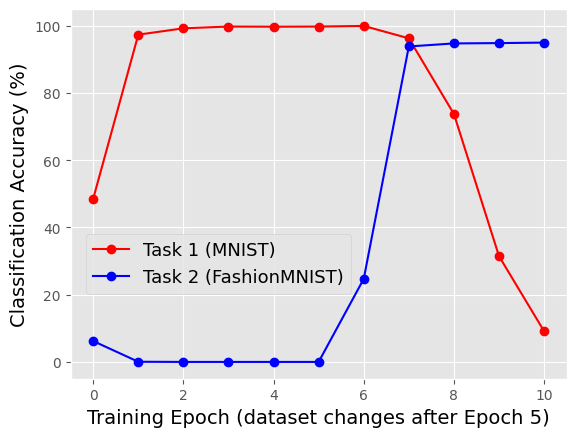

In [20]:
# Evolution of performance on both tasks

plt.plot(steps, mnist_acc, "-or", label="Task 1 (MNIST)")
plt.plot(steps, f_mnist_acc, "-ob", label="Task 2 (FashionMNIST)")

plt.xlabel('Training Epoch (dataset changes after Epoch 5)', fontsize=14, color='black')
plt.ylabel('Classification Accuracy (%)', fontsize=14, color='black')

plt.legend(loc=(0.03, 0.23), fontsize=13)
plt.show()

# Optogenetic memory recovery

In [21]:
optogenetic_strength = 1.7

# Evaluation
with torch.no_grad():
    correct = 0
    total = 0
    model.eval() # Set model in eval mode. Don’t forget!
    for data in test_loader:
        images, labels = data
        images = images.view(-1, 28*28)
        images = images.to(device)
        labels = labels.to(device) # shape (B)
        outputs = model(images, weight_task_one=optogenetic_strength) # shape (B, num_classes)
        _, predicted = outputs.max(dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_acc = 100 * correct / total
print(f'MNIST Test accuracy: {test_acc} %')

MNIST Test accuracy: 98.53427895981088 %


# Ablation on optogenetic strength

In [22]:
strength = []
for i in range(10):
    strength.append(1. + i*0.1)

In [23]:
acc = []

for optogenetic_strength in strength:

    # Evaluation
    with torch.no_grad():
        correct = 0
        total = 0
        model.eval() # Set model in eval mode. Don’t forget!
        for data in test_loader:
            images, labels = data
            images = images.view(-1, 28*28)
            images = images.to(device)
            labels = labels.to(device) # shape (B)
            outputs = model(images, weight_task_one=optogenetic_strength) # shape (B, num_classes)
            _, predicted = outputs.max(dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_acc = 100 * correct / total
        acc.append(test_acc)
        print(f'[strength = {optogenetic_strength:.1f}] Task 1 (MNIST) Test accuracy: {test_acc:.2f} %')

[strength = 1.0] Task 1 (MNIST) Test accuracy: 9.13 %
[strength = 1.1] Task 1 (MNIST) Test accuracy: 28.65 %
[strength = 1.2] Task 1 (MNIST) Test accuracy: 55.51 %
[strength = 1.3] Task 1 (MNIST) Test accuracy: 77.73 %
[strength = 1.4] Task 1 (MNIST) Test accuracy: 89.22 %
[strength = 1.5] Task 1 (MNIST) Test accuracy: 94.52 %
[strength = 1.6] Task 1 (MNIST) Test accuracy: 97.26 %
[strength = 1.7] Task 1 (MNIST) Test accuracy: 98.53 %
[strength = 1.8] Task 1 (MNIST) Test accuracy: 99.10 %
[strength = 1.9] Task 1 (MNIST) Test accuracy: 99.48 %


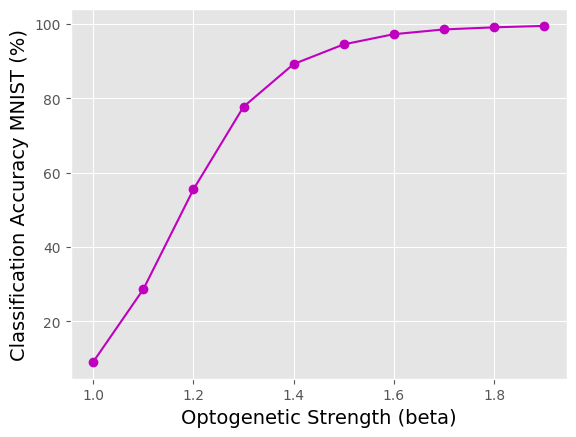

In [24]:
# plt.scatter(x=strength, y=acc)
plt.plot(strength, acc, "-om")

plt.xlabel('Optogenetic Strength (beta)', fontsize=14, color='black')
plt.ylabel('Classification Accuracy MNIST (%)', fontsize=14, color='black')

plt.show()